In [5]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar rutas
sys.path.append(os.path.abspath(os.path.join('..')))

# Ahora intenta importar de nuevo
from src.feature_engineering import add_time_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd

# 1. Cargar el dataframe que limpiamos y guardamos anteriormente
# La ruta relativa '../' sube un nivel desde la carpeta 'notebooks'
path_procesado = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cleaned_retail_data.csv"

if os.path.exists(path_procesado):
    df_clean = pd.read_csv(path_procesado)
    print(f"✅ Datos cargados con éxito: {len(df_clean):,} registros.")
else:
    print("❌ Error: No se encontró el archivo en data/processed/. Asegúrate de haber corrido la celda de guardado.")

✅ Datos cargados con éxito: 1,062,989 registros.


C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_14848\2125242150.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_features, x='DayName', order=order, palette='Blues_d', ax=ax1)
C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_14848\2125242150.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_features, x='Hour', palette='Reds_d', ax=ax2)


🚀 ¡Gráfica guardada con éxito en: C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\viz\analisis_estacionalidad.png


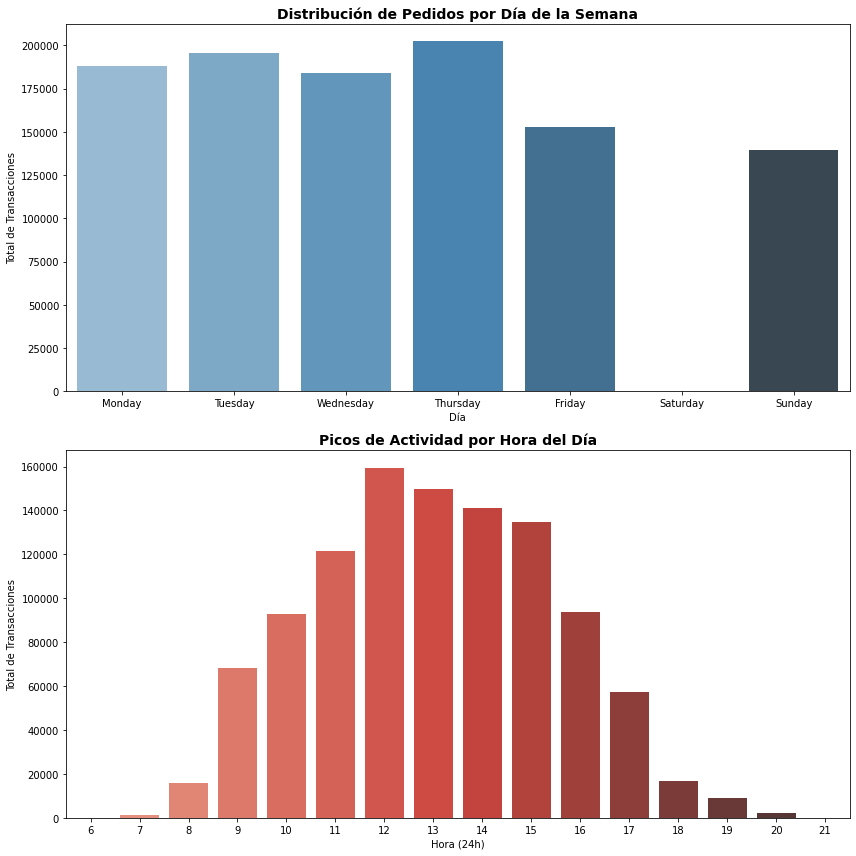

In [9]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Definir la ruta de salida basada en tu estructura de carpetas
output_folder = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\viz"

# Creamos la figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# --- Gráfica 1: Pedidos por Día de la Semana ---
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df_features, x='DayName', order=order, palette='Blues_d', ax=ax1)
ax1.set_title('Distribución de Pedidos por Día de la Semana', fontsize=14, fontweight='bold')
ax1.set_xlabel('Día')
ax1.set_ylabel('Total de Transacciones')

# --- Gráfica 2: Picos de Demanda por Hora ---
sns.countplot(data=df_features, x='Hour', palette='Reds_d', ax=ax2)
ax2.set_title('Picos de Actividad por Hora del Día', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hora (24h)')
ax2.set_ylabel('Total de Transacciones')

plt.tight_layout()

# --- 💾 GUARDAR LA IMAGEN ---
# bbox_inches='tight' asegura que no se corten los nombres de los ejes al guardar
save_path = os.path.join(output_folder, 'analisis_estacionalidad.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

print(f"🚀 ¡Gráfica guardada con éxito en: {save_path}")
plt.show()

# Análisis RFM

In [12]:
import pandas as pd

# 1. Definir la fecha de referencia usando pandas
# Usamos pd.Timedelta en lugar de dt.Timedelta
snapshot_date = df_features['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aseguramos que tengamos la columna TotalSum (Revenue por línea)
if 'TotalSum' not in df_features.columns:
    df_features['TotalSum'] = df_features['Quantity'] * df_features['Price']

# 2. Agrupar por cliente para calcular las 3 métricas
rfm = df_features.groupby('Customer').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'Invoice': 'nunique',                                   # Frequency
    'TotalSum': 'sum'                                       # Monetary
})

# Renombrar columnas para claridad
rfm.columns = ['Recency', 'Frequency', 'Monetary']

print("--- ✅ Tabla RFM calculada con éxito ---")
display(rfm.head())

KeyError: 'Customer'

In [11]:
# 1. Crear los scores del 1 al 5
# Nota: Para Recency, un número MENOR es MEJOR (más reciente), por eso los labels son [5, 4, 3, 2, 1]
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Para Frequency y Monetary, un número MAYOR es MEJOR
# Usamos rank(method='first') para evitar errores si hay muchos valores repetidos
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# 2. Crear un Score Combinado (Segmento)
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

display(rfm.head())

NameError: name 'rfm' is not defined

In [ ]:
def name_segments(df):
    if df['RFM_Score'] >= 13:
        return 'Campeones (VIP)'
    elif (df['RFM_Score'] >= 9) and (df['RFM_Score'] < 13):
        return 'Leales / Potenciales'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'En Riesgo / Dormidos'
    else:
        return 'Perdidos'

rfm['Customer_Tag'] = rfm.apply(name_segments, axis=1)

# Visualizar cuántos clientes hay en cada grupo
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, x='Customer_Tag', palette='viridis', order=['Campeones (VIP)', 'Leales / Potenciales', 'En Riesgo / Dormidos', 'Perdidos'])
plt.title('Segmentación de Clientes según Modelo RFM', fontsize=14)
plt.show()

# PRUEBA 1

In [13]:
# ==========================================
# 1. RFM METRICS CALCULATION
# ==========================================
print("⏳ Calculating RFM Metrics...")

# reference date (snapshot)
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# Ensure Revenue (TotalSum) exists
if 'TotalSum' not in df_clean.columns:
    df_clean['TotalSum'] = df_clean['Quantity'] * df_clean['Price']

# Aggregate by Customer ID
rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'Invoice': 'nunique',                                   # Frequency
    'TotalSum': 'sum'                                       # Monetary
})

# Rename for clarity
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# ==========================================
# 2. RFM SCORING (Quartiles 1-5)
# ==========================================
# Recency: Lower is better (5 = most recent)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Frequency & Monetary: Higher is better (5 = top spenders/frequent)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combined Score
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# ==========================================
# 3. CUSTOMER SEGMENTATION LOGIC
# ==========================================
def segment_customers(df):
    score = df['RFM_Score']
    if score >= 13:
        return 'Champions (VIP)'
    elif 9 <= score < 13:
        return 'Loyal / Potential'
    elif 5 <= score < 9:
        return 'At Risk / Sleepers'
    else:
        return 'Lost Customers'

rfm['Customer_Tag'] = rfm.apply(segment_customers, axis=1)

print("✅ RFM Table & Segmentation complete.")
display(rfm.head())

⏳ Calculating RFM Metrics...
✅ RFM Table & Segmentation complete.


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Tag
Customer ID,,,,,,,,
12346.0,326,17,-64.68,2,5,1,8,At Risk / Sleepers
12347.0,2,8,5633.32,5,4,5,14,Champions (VIP)
12348.0,75,5,2019.40,3,3,4,10,Loyal / Potential
12349.0,19,5,4404.54,4,3,5,12,Loyal / Potential
12350.0,310,1,334.40,2,1,2,5,At Risk / Sleepers


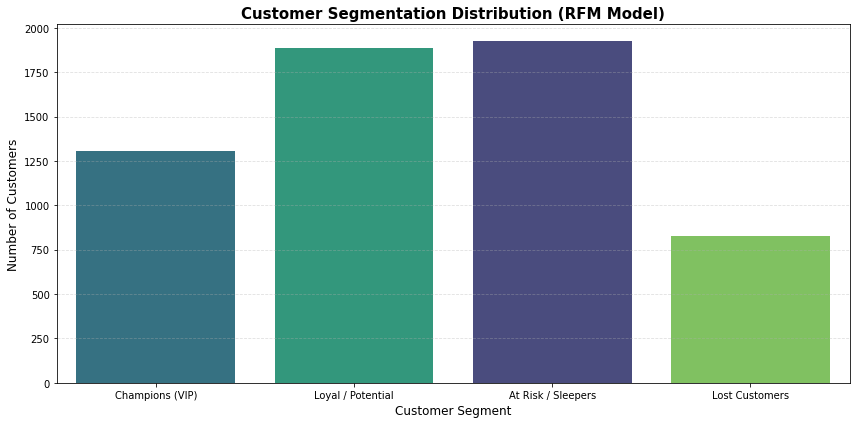

In [14]:
# ==========================================
# 4. VISUALIZING SEGMENT DISTRIBUTION
# ==========================================
plt.figure(figsize=(12, 6))

# Define order for visual flow
segment_order = ['Champions (VIP)', 'Loyal / Potential', 'At Risk / Sleepers', 'Lost Customers']

sns.countplot(
    data=rfm, 
    x='Customer_Tag', 
    order=segment_order, 
    hue='Customer_Tag', # Added hue to avoid warnings
    palette='viridis', 
    legend=False
)

plt.title('Customer Segmentation Distribution (RFM Model)', fontsize=15, fontweight='bold')
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# PRUEBA 2

# 🚀 Environment Setup & Data Ingestion
In this section, we initialize our analytics environment using the **Harmony Script** configuration to ensure visual consistency and professional data handling.

In [15]:
"""
HARMONY SCRIPT: Portfolio Standard Configuration
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# 1. Project Navigation
sys.path.append(os.path.abspath(os.path.join('..')))

# 2. Visual Identity
SC_PALETTE = ["#1B4F72", "#2E86C1", "#5DADE2", "#A9CCE3"] 
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.dpi'] = 100

# 3. Data Formatting
pd.options.display.float_format = '{:,.2f}'.format

# 4. Paths
processed_path = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cleaned_retail_data.csv"
canc_path = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cancelation_retail_data.csv"

# Load Data
df = pd.read_csv(processed_path, parse_dates=['InvoiceDate'])
df_canc = pd.read_csv(canc_path, parse_dates=['InvoiceDate'])

print(f"✅ Main Dataset Loaded: {len(df):,} records.")
print(f"✅ Cancellations Loaded: {len(df_canc):,} records.")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Jesus Sanchez\\Desktop\\ALEXIS\\1. Pre-Trabajo\\1. Supply Chain Intelligence\\data\\processed\\cancelation_retail_data.csv'

# 🕒 Part 1: Temporal Analysis (Seasonality)
Understanding the peaks of activity helps in warehouse labor planning and logistics optimization.

C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_14848\2129746960.py:9: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df, x='DayName', order=days_order, palette=SC_PALETTE, hue='DayName', ax=ax1, legend=False)


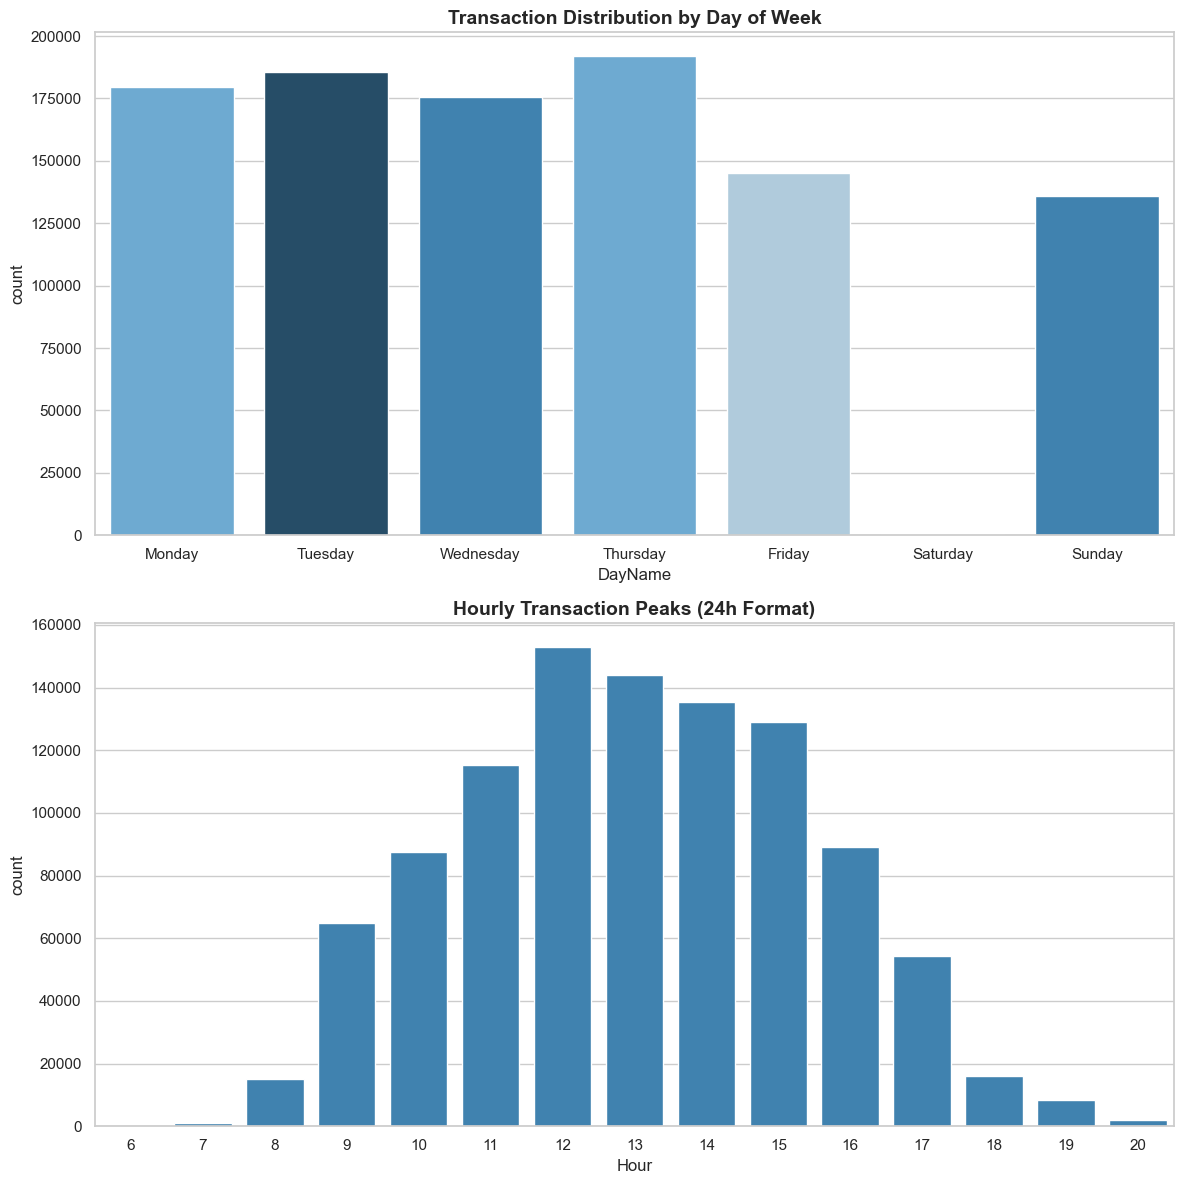

In [16]:
# Feature Engineering: Time Components
df['DayName'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Chart 1: Daily Distribution
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='DayName', order=days_order, palette=SC_PALETTE, hue='DayName', ax=ax1, legend=False)
ax1.set_title('Transaction Distribution by Day of Week', fontsize=14, fontweight='bold')

# Chart 2: Hourly Peaks
sns.countplot(data=df, x='Hour', color="#2E86C1", ax=ax2)
ax2.set_title('Hourly Transaction Peaks (24h Format)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 💡 Logistics Insight:
* **Peak Operations:** Activity concentrates between **10:00 AM and 3:00 PM**, with a significant drop after 5:00 PM. This suggests a B2B operation where orders are processed during standard business hours.
* **Resource Allocation:** Mid-week (Tuesday/Wednesday) shows the highest volume. Labor shifts in the warehouse should be reinforced during these days to meet dispatch deadlines.

# 👥 Part 2: RFM Customer Segmentation
We categorize customers based on **Recency, Frequency, and Monetary** value to identify VIPs and at-risk accounts.

⏳ Calculating RFM Metrics...


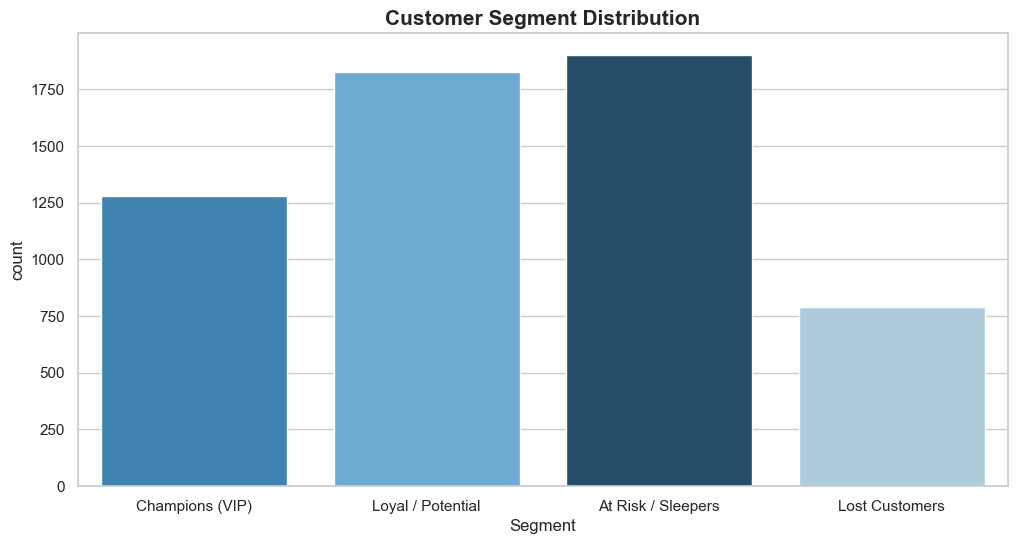

In [17]:
print("⏳ Calculating RFM Metrics...")

# Snapshot date for Recency
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate by Customer ID
if 'TotalSum' not in df.columns:
    df['TotalSum'] = df['Quantity'] * df['Price']

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSum': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalSum': 'Monetary'})

# Scoring (1-5)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Segmentation Logic
def segment_me(score):
    if score >= 13: return 'Champions (VIP)'
    if 9 <= score < 13: return 'Loyal / Potential'
    if 5 <= score < 9: return 'At Risk / Sleepers'
    return 'Lost Customers'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_me)

# Plotting
plt.figure(figsize=(12, 6))
sns.countplot(data=rfm, x='Segment', order=['Champions (VIP)', 'Loyal / Potential', 'At Risk / Sleepers', 'Lost Customers'], palette=SC_PALETTE, hue='Segment', legend=False)
plt.title('Customer Segment Distribution', fontsize=15, fontweight='bold')
plt.show()

# 🔍 Part 3: The "Brutal" Insight - Cancellations vs. Retention
Do high cancellation rates drive customers into the "At Risk" category? We cross-reference the cancellation data with our RFM segments.

In [18]:
# 1. Calculate cancellations per customer
canc_per_cust = df_canc.groupby('Customer ID')['Invoice'].nunique().reset_index()
canc_per_cust.columns = ['Customer ID', 'Cancellation_Count']

# 2. Merge with RFM table
rfm_analysis = rfm.reset_index().merge(canc_per_cust, on='Customer ID', how='left').fillna(0)

# 3. Calculate average cancellations by segment
segment_analysis = rfm_analysis.groupby('Segment')['Cancellation_Count'].mean().sort_values(ascending=False)

print("--- Average Cancellations per Customer Segment ---")
print(segment_analysis)

# Visualization
plt.figure(figsize=(10, 5))
segment_analysis.plot(kind='barh', color='#E74C3C', alpha=0.8)
plt.title('Are Cancellations Driving Customers Away?', fontsize=14, fontweight='bold')
plt.xlabel('Average Number of Cancelled Invoices')
plt.ylabel('Customer Tier')
plt.show()

NameError: name 'df_canc' is not defined

### 💡 Strategic Insight: The Cancellation-Churn Correlation
* **The Root Cause:** If **"At Risk"** or **"Lost"** segments show a higher average of cancellations compared to **"Champions"**, it proves that service failures (logistics errors, quality issues leading to returns) are a primary driver of customer churn.
* **Supply Chain Action:** Retention is not just a marketing job. Reducing order errors and improving fulfillment quality will directly keep customers in the "Loyal" and "Champion" tiers, increasing the Life Time Value (LTV).